In [106]:
import requests
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import tplquad

def read_table_from_url(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            lines = response.text.split('\n')
            table_data = []
            for line in lines:
                # Skip comment lines starting with '#'
                if not line.startswith('#'):
                    # Split the line by whitespace and filter out empty elements
                    row = list(filter(None, line.strip().split()))
                    if row:
                        table_data.append(row)
            return table_data
        else:
            print("Failed to fetch data. Status code:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None
#change the address where to take the table
url_agss09 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09.dat"
url_gs98 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_gs98.dat"
url_agss09ph = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09ph.dat"
url_ags05 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_ags05.dat"
#change url here below
table_data = read_table_from_url(url_ags05)
#print("Properties of the solar model", table_data[1968:])
table_data = table_data[11:1968]
# Determine the number of rows and columns
num_rows = len(table_data)
num_columns = len(table_data[0]) if table_data else 0

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# Check if every row has the same number of elements
num_columns = len(table_data[0]) if table_data else 0
consistent = all(len(row) == num_columns for row in table_data)

if consistent:
    print("Every row has the same number of elements.")
else:
    print("Not every row has the same number of elements.")


# Convert table data to numpy arrays
table_data = np.array(table_data, dtype=float)

# Extract columns from the table data
mass_fraction = table_data[:, 0]
radius = table_data[:, 1]
temperature = table_data[:, 2]
density = table_data[:, 3]
pressure = table_data[:, 4]
luminosity_fraction = table_data[:, 5]

# Extract mass fractions of elements
element_mass_fractions = table_data[:, 6:]

# Interpolate each quantity as a function of radius
radius_interp_func = interp1d(radius, radius)
temperature_interp_func = interp1d(radius, temperature)
density_interp_func = interp1d(radius, density)
pressure_interp_func = interp1d(radius, pressure)
luminosity_interp_func = interp1d(radius, luminosity_fraction)

# Extract mass fractions of elements
element_mass_fractions = [table_data[:, i] for i in range(6, table_data.shape[1])]

# Interpolate mass fractions of elements as a function of radius
element_interp_funcs = []
for mass_fraction_array in element_mass_fractions:
    interp_func = interp1d(radius, mass_fraction_array, kind='linear')
    element_interp_funcs.append(interp_func)

atomic_numbers = [1, 2, 2, 6, 6, 7, 7, 8, 8, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
atomic_mass_numbers = [1, 4, 3, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 27, 28, 31, 32, 35, 40, 39, 40, 45, 48, 51, 52, 55, 56, 59, 59]

def kappa(radius):
    mu = 930 #MeV
    alpha= 1/137
    
    element_mass_fractions = [interp_func(radius) for interp_func in element_interp_funcs]
    ne = 0
    nbar = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
        nbar = nbar + (atomic_numbers[i]**2)*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    nbar = nbar * 0.561e+27 #in cm^-3
    res = np.sqrt(4*np.pi*alpha*(ne+nbar)/temperature_interp_func(radius))
    return res*9.43924e-9 #in keV

def omega_p(radius):
    mu = 930 #MeV
    alpha= 1/137
    me = 0.511 #MeV
    
    element_mass_fractions = [interp_func(radius) for interp_func in element_interp_funcs]
    ne = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    res = np.sqrt(4*np.pi*alpha*ne/me)
    return res*8.76376e-14 #in keV


# Define constants
D_sun = 1.49e13  # Earth-Sun distance in cm

# Define the ALP production rate function. r in Rsun, omega_a and ma in keV,  model=+,-
def I(u, y):
    integrand = lambda x: x * np.exp(-x**2) * quad(lambda t: t / (t**2 + y**2), np.sqrt(x**2 + u) - x, np.sqrt(x**2 + u) + x)[0]
    return quad(integrand, 0, np.inf)[0]

def G_ff_z(omega, r, zindex): #omega in keV, zindex between 0 and 29
    """
    Partial function G_ff_z
    """
    mu = 930 #MeV
    Tv = temperature_interp_func(r).item() * 8.617e-8 #keV
    rhov = density_interp_func(r).item()
    m_e = 511 #keV
    alpha_EM = 1/137
    prefactor = (8 * np.pi) / (3 * np.sqrt(2 * np.pi))
    denominator = np.sqrt(Tv) * m_e**(7/2) * omega #keV^5
    exponential_term = np.exp(-omega / Tv)
    y = kappa(r)/np.sqrt(2*m_e*Tv)  
    integral_term = I(omega / Tv, y)
    element_mass_fractions = [interp_func(r) for interp_func in element_interp_funcs]
    
    Q_z = atomic_numbers[zindex]
    n_z = 5.61e26*element_mass_fractions[zindex]*rhov/(atomic_mass_numbers[zindex]*mu) #cm^-3

    ne = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(r)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    
    return prefactor * (alpha_EM**2) * (Q_z**2) * n_z * ne / denominator * exponential_term * integral_term *5.898e-47 #keV

def G_ff(omega, r):
    """
    Function G_ff
    """
    res = 0
    for i in range(0,len(atomic_numbers)):
        res = res + G_ff_z(omega, r, i)
    return res #keV

def G_ee(omega, r): #omega in keV, zindex between 0 and 29
    """
    Partial function G_ee
    """
    mu = 930 #MeV
    Tv = temperature_interp_func(r).item() * 8.617e-8 #keV
    rhov = density_interp_func(r).item()
    m_e = 511 #keV
    alpha_EM = 1/137
    prefactor = (4 * np.sqrt(np.pi)) / 3
    denominator = np.sqrt(Tv) * m_e**(7/2) * omega #keV^5
    exponential_term = np.exp(-omega / Tv)
    y = kappa(r)/np.sqrt(2*m_e*Tv)  
    integral_term = I(omega / Tv, np.sqrt(2)*y)
    element_mass_fractions = [interp_func(r) for interp_func in element_interp_funcs]
    
    ne = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*rhov/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    
    return prefactor * (alpha_EM**2) * (ne**2) / denominator * exponential_term * integral_term *5.898e-47 #keV

def G_C(omega, r): #omega in keV, zindex between 0 and 29
    """
    Partial function G_C
    """
    mu = 930 #MeV
    Tv = temperature_interp_func(r).item() * 8.617e-8 #keV
    rhov = density_interp_func(r).item()
    m_e = 511 #keV
    alpha_EM = 1/137
    denominator = 3 * m_e**4 #keV^4
    exponential_term = 1 / (np.exp(omega / Tv)-1)
    element_mass_fractions = [interp_func(r) for interp_func in element_interp_funcs]
    
    ne = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*rhov/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    
    return alpha_EM * ne * (omega**2) / denominator * exponential_term * 7.68e-24 #keV



# Define the function dN_a_dt_dw_a. omega_a and ma in keV, gae
def dNdtdw_brem(omega_a, gae):
    # Define the integrand function
    def integrand(r, omega_a):
        return ((4 * np.pi)**2) * (r**2) * (omega_a**2) * (G_ff(omega_a, r)+G_ee(omega_a, r)) / ((2 * np.pi)**3)
    # keV^3
    
    # Perform the integral
    r_min = table_data[:, 1].min()  
    r_max = table_data[:, 1].max()  
    result, _ = quad(integrand, r_min, r_max, args=(omega_a))
    
    # Evaluate the flux
    return ((gae**2) / (4 * np.pi * D_sun**2)) * result * 6.666e73# in cm^-2 keV^-1 s^-1

# Define the function dN_a_dt_dw_a. omega_a and ma in keV, gae
def dNdtdw_compton(omega_a, gae):
    # Define the integrand function
    def integrand(r, omega_a):
        return ((4 * np.pi)**2) * (r**2) * (omega_a**2) * (G_C(omega_a, r)) / ((2 * np.pi)**3)
    # keV^3
    
    # Perform the integral
    r_min = table_data[:, 1].min()  
    r_max = table_data[:, 1].max() 
    result, _ = quad(integrand, r_min, r_max, args=(omega_a))
    
    # Evaluate the flux
    return ((gae**2) / (4 * np.pi * D_sun**2)) * result * 6.666e73# in cm^-2 keV^-1 s^-1

Number of rows: 1957
Number of columns: 35
Every row has the same number of elements.


/tmp/ipykernel_52137/3709930530.py:193: RuntimeWarning: overflow encountered in exp
  exponential_term = 1 / (np.exp(omega / Tv)-1)
/tmp/ipykernel_52137/1781556349.py:15: RuntimeWarning: overflow encountered in power
  return params[0] * ((omega/params[1])**params[2]) * np.exp(-(1+params[2]) * (omega/params[1]))
/tmp/ipykernel_52137/1781556349.py:15: RuntimeWarning: overflow encountered in multiply
  return params[0] * ((omega/params[1])**params[2]) * np.exp(-(1+params[2]) * (omega/params[1]))


Optimized parameters: [8.70466540e+10 5.07481047e+00 2.97982618e+00]


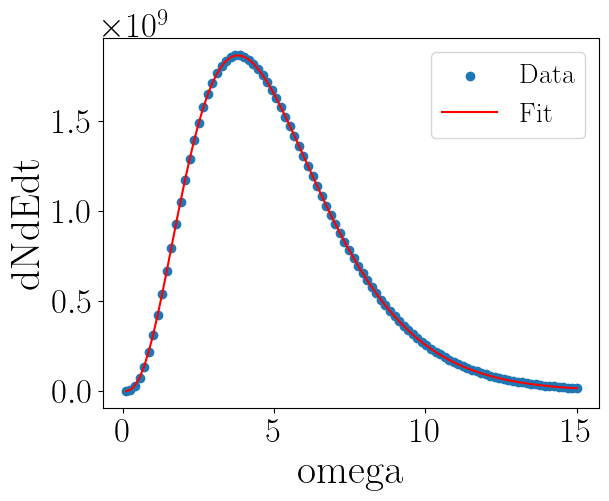

In [107]:
gae = 1.e-12 
omega_min = 0.1
omega_max = 15
num_points = 100
omega_values = np.linspace(omega_min, omega_max, num_points) #keV

# Calculate dNdEdt for each omega value
dNdEdt_values = np.array([dNdtdw_compton(omg, gae) for omg in omega_values])


# Define your functional form
def your_function(omega, *params):
    # Your functional form here
    # Example:
    return params[0] * ((omega/params[1])**params[2]) * np.exp(-(1+params[2]) * (omega/params[1]))

# Perform the fit
params_guess = [1.e+8, 3, 2]  # Initial guess for parameters
params_opt, params_cov = curve_fit(your_function, omega_values, dNdEdt_values, p0=params_guess)

# params_opt contains optimized parameters
# params_cov contains covariance matrix

# Print the optimized parameters
print("Optimized parameters:", params_opt)

plt.scatter(omega_values, dNdEdt_values, label='Data')
plt.plot(omega_values, your_function(omega_values, *params_opt), color='red', label='Fit')
plt.xlabel('omega')
plt.ylabel('dNdEdt')
plt.legend()
plt.show()

In [122]:
import numpy as np

def dPhi_dE(E, C0, gae, E0, beta):
    return C0 * (gae / 1e-12)**2 * (E / E0)**beta * np.exp(-(1 + beta) * (E / E0))

def axion_flux(E, flux_type='bremsstrahlung', error=False):
    if flux_type == 'bremsstrahlung':
        if error:
            C0 = (3.847 - 0.007) * 1e11  # Lower bound of C0
            E0 = (1.63 - 0.01)  # Lower bound of E0
            beta = 0.8063 - 0.0003  # Lower bound of beta
        else:
            C0 = (3.847 + 0.007) * 1e11  # Lower bound of C0
            E0 = (1.63 + 0.01)  # Lower bound of E0
            beta = 0.8063 + 0.0003  # Lower bound of beta
    elif flux_type == 'Compton':
        if error:
            C0 = (8.8 - 0.1) * 1e11  # Lower bound of C0
            E0 = (5.10 - 0.03)  # Lower bound of E0
            beta = 2.979 - 0.001  # Lower bound of beta
        else:
            C0 = (8.8 + 0.1) * 1e11  # Lower bound of C0
            E0 = (5.10 + 0.03)  # Lower bound of E0
            beta = 2.979 + 0.001  # Lower bound of beta
    else:
        raise ValueError("Invalid flux type. Choose 'bremsstrahlung' or 'Compton'.")
    
    gae = 1.e-12  # gae change
    return dPhi_dE(E, C0, gae, E0, beta)

# Example usage:
# Define the integrand, cm^-2 keV^-1 s^-1
integrand1 = lambda E: axion_flux(E, flux_type='Compton', error=False)
# Perform the integration
result1, _ = quad(integrand1, 0, np.inf)  # Integrating from 0 to infinity


integrand2 = lambda E: E*axion_flux(E, flux_type='Compton', error=False)
# Perform the integration
result2, _ = quad(integrand2, 0, np.inf)  # Integrating from 0 to infinity
result2 = result2 * (4 * np.pi * D_sun**2)*1.602e-9 / 3.846e33 #L_sun

print("Integral flux s^-1 cm^-2", result1*1.e-11)
print("Integral luminosity in L_sun",result2*1.e4)


Integral flux s^-1 cm^-2 1.0945565264861987
Integral luminosity in L_sun 6.525160412148369


In [124]:
cmin=6.244
cmax=6.525
print((cmin+cmax)/2)
print(np.abs(cmin-cmax)/2)

6.3845
0.1405000000000003
